In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Syntax validation: Kuramoto data generation and kernel test

In [2]:
#------------------------------------------------------------------------------
# define data and initialize simulation
L    = 50/(2*np.pi)
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)


N_data_train = 10000
N_data_test = 10000
dl_max = 20000
pl_max = 20000


#------------------------------------------------------------------------------
# simulate initial transient
dns.simulate()
print(dns.uu.shape)

u = dns.uu[ninittransients:]
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)
print("Data shape: ")
print(u_test.shape)
print(u_train.shape)

(21001, 100)
Data shape: 
(10000, 100)
(10000, 100)


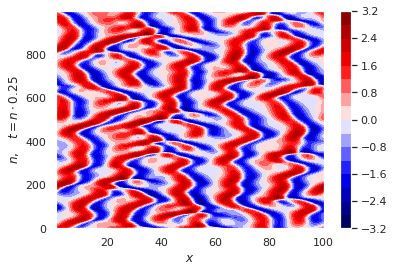

In [3]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [2]:
#arcsin kernel
def gaussian_data(n_input, input_len_max, input_dim,fix_seed= False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

n_input = 50 # number of time series
input_len = 40 # time steps t
input_dim = 100 #dimension of the time series
scale_in = 1  # variance of input
scale_res = 1 # variance of reservoir

torch.manual_seed(123)
# input_data = gaussian_data(n_input, input_len, input_dim)

loss = torch.nn.MSELoss()

n_res_range = np.arange(start=100,stop=1000, step=100)
error_gauss_asin = torch.zeros(len(n_res_range))

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    K = computekernel.arcsin(input_data, initial_state, scale_res)
    X_final = torch.zeros((n_input,n_res)).to(device)
    for n_in in range(n_input):
        model = reservoir.ESN(input_dim, reservoir_size=n_res, scale_res = scale_res, scale_in = scale_in,f='erf')
        X = model.forward(input_data[n_in,:,:].reshape(input_len,input_dim), initial_state = initial_state).to(device)
        X_final[n_in,:] = X[-1,:]
    
    K_hat = torch.matmul(X_final,X_final.t())
    error_gauss_asin[i] = loss(K_hat,K) / loss(K, torch.zeros(n_input, n_input).to(device))

9it [00:02,  3.47it/s]


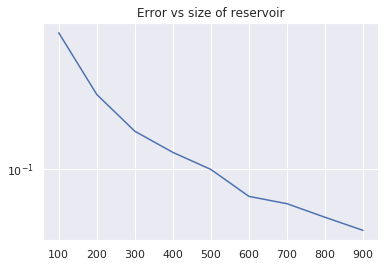

In [3]:
plt.semilogy(n_res_range, error_gauss_asin.numpy())
plt.title('Error vs size of reservoir');

# Prediction on Kuramoto

To be checked: normalization of the input

In [203]:
u_train_t = torch.from_numpy(u_train).to(device)
pred_horizon = 30

n_input = 1 # number of time series
input_len, input_dim = u_train_t.shape # time steps t
# input_dim = 32 #dimension of the time series
scale_in = 0.1  # variance of input
scale_res = 1 # variance of reservoir

n_res = 1000
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, reservoir_size=n_res, scale_res=scale_res, scale_in=scale_in, f='erf', leak_rate=1)
X = model.forward(u_train_t, initial_state=initial_state).to(device)
print(X.shape)

torch.Size([10000, 1000])


In [204]:
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
print(out_train.shape)

torch.Size([10000, 100])


In [205]:
from sklearn.linear_model import Ridge
clf = Ridge(fit_intercept=False, alpha=1e-3)
clf.fit(X.cpu().numpy(), out_train.cpu().numpy())
output_w = torch.from_numpy(clf.coef_.T).to(device)
print(output_w.shape)

pred_output = X @ output_w

torch.Size([1000, 100])


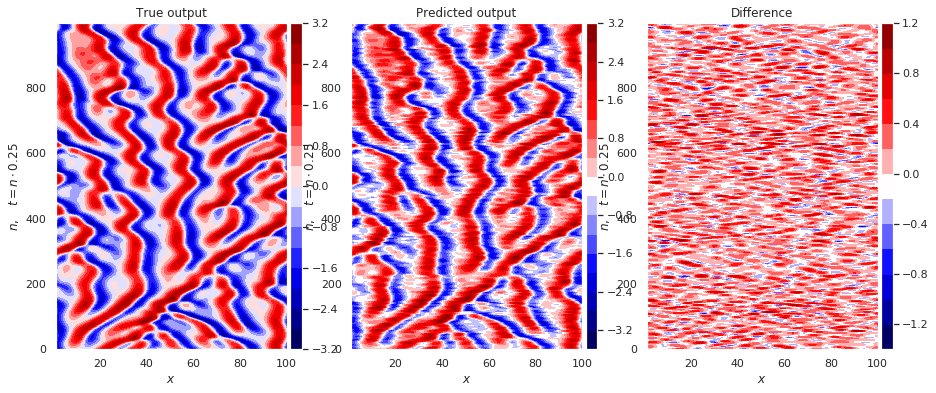

In [206]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_train.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output-out_train).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

# Prediction on Kuramoto (with more data for training)

In [207]:
u_train_t = torch.from_numpy(u_train).to(device)
pred_horizon = 30

n_input = 1 # number of time series
input_len, input_dim = u_train_t.shape # time steps t
# input_dim = 32 #dimension of the time series
scale_in = 0.1  # variance of input
scale_res = 1 # variance of reservoir

n_res = 1000
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, reservoir_size=n_res, scale_res=scale_res, scale_in=scale_in, f='erf', leak_rate=1)
X = model.forward(u_train_t, initial_state=initial_state).to(device)
print(X.shape)

torch.Size([10000, 1000])


In [208]:
X2 = torch.cat((X, u_train_t), 1)
print(X2.shape)

torch.Size([10000, 1100])


In [209]:
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
print(out_train.shape)

torch.Size([10000, 100])


In [210]:
from sklearn.linear_model import Ridge
clf = Ridge(fit_intercept=False, alpha=1e-3)
clf.fit(X2.cpu().numpy(), out_train.cpu().numpy())
output_w = torch.from_numpy(clf.coef_.T).to(device)
print(output_w.shape)

pred_output = X2 @ output_w

torch.Size([1100, 100])


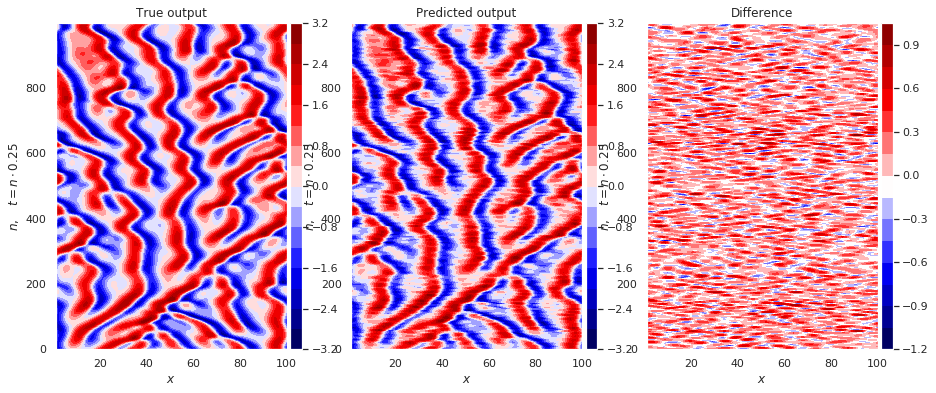

In [211]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_train.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output-out_train).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

It works okay, and gets better with 5'000 neurons.

# Stability test

In [212]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 100
input_data = input_data[:input_len, :]
# input_data /= np.sqrt(input_data.shape[1])

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
# input_dim = 32 #dimension of the time series
scale_in = 0.1  # variance of input
scale_res = 1 # variance of reservoir

n_res = 1000
torch.manual_seed(1)
initial_state1 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, reservoir_size=n_res, scale_res=scale_res, scale_in=scale_in, f='erf', leak_rate=1)
X1 = model.forward(input_data, initial_state=initial_state1).to(device)

torch.manual_seed(2)
initial_state2 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, reservoir_size=n_res, scale_res=scale_res, scale_in=scale_in, f='erf', leak_rate=1)
X2 = model.forward(input_data, initial_state=initial_state2).to(device)

torch.Size([100, 1000])


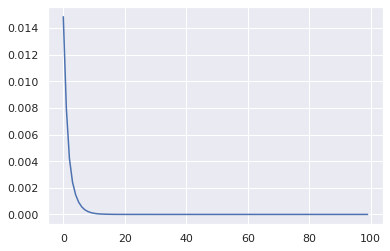

In [213]:
diff = X2 - X1
print(diff.shape)
plt.plot(torch.mean(torch.abs(diff), axis=1).cpu())

We will thus take 100 steps to initialize our recursive kernels (so that they don't depend on the initial state).

# Recursive kernel computation

In [19]:
input_data = torch.from_numpy(u_train).to(device)
input_data = input_data[:4000, :]

length_of_interest = 99
input_len, input_dim = input_data.shape # time steps t
n_input = input_len - length_of_interest
input_len = length_of_interest

gram_input = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input[i_in, :, :] = input_data[i_in:i_in+input_len, :]
print(gram_input.shape)
print(gram_input[:2, :5, 0])

torch.Size([3901, 99, 100])
tensor([[1.5388, 1.4661, 1.3914, 1.3150, 1.2371],
        [1.4661, 1.3914, 1.3150, 1.2371, 1.1582]], device='cuda:0')


In [20]:
torch.manual_seed(1)
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)

K = computekernel.arcsin(gram_input, initial_state, scale_res=1, scale_in=0.1)
print(K.shape)

torch.Size([3901, 3901])


In [21]:
pred_horizon = 30

out_train = torch.roll(input_data, -pred_horizon, dims=0)
out_train = out_train[length_of_interest:, :]
print(out_train.shape)

torch.Size([3901, 100])


In [22]:
from sklearn.linear_model import Ridge
clf = Ridge(fit_intercept=False, alpha=1e-3)
clf.fit(K.cpu().numpy(), out_train.cpu().numpy())
output_w = torch.from_numpy(clf.coef_.T).to(device)
print(output_w.shape)

pred_output = K @ output_w

torch.Size([3901, 100])


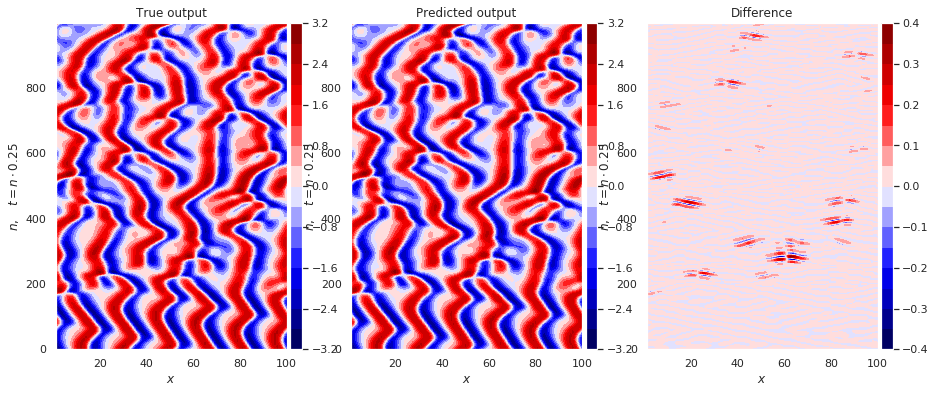

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_train.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output-out_train).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

# Next steps

This is done on the training data. It is normal that the recursive kernel works well on the training dat (number of parameters = number of examples). We need to it on a testing set.

To do it:
- For the Reservoir Computing half, it's quite easy. Just iterate the reservoir again and use the output weights
- For the Recurrent Kernel half, the Gram vector needs to be computed, so all the training data points need to be kept in memory.